In [1]:
!pip install segmentation_models_pytorch


  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.3 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Importing  libararies

In [2]:
# Importing the libraries and pytorch
import json
import os
import torch
import cv2
import numpy as np
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
#import tensorboard for pytorch
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
tensorboard_writer = SummaryWriter()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Prepare the data

this custom dataset load the data and apply transformation to it

In [3]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, transformations=None):
        self.im_paths = sorted(glob("/kaggle/input/uploud/*.jpg"))
        self.mask_paths = [im_path for im_path in sorted(glob("/kaggle/input/uploud/*.png")) if "fuse" in im_path]
        self.transformations = transformations
        self.n_cls = 11
        assert len(self.im_paths) == len(self.mask_paths)

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im, mask = self.get_im_mask(self.im_paths[idx], self.mask_paths[idx])
        if self.transformations:
            im, mask = self.apply_transformations(im, mask)
        return im, mask

    def get_im_mask(self, im_path, mask_path):
        return self.read_im(im_path), self.read_im(mask_path)

    def read_im(self, path):
        return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, mask):
        transformed = self.transformations(image=im, mask=mask)
        return transformed["image"], transformed["mask"]


In [4]:
# Cell 3: Define the get_dls function
def get_data_loaders(transformations, batch_size, split=[0.9, 0.05, 0.05]):
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    ds = CustomSegmentationDataset(transformations=transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    data_loaders= {
        "train": DataLoader(tr_ds, batch_size=batch_size, shuffle=True),
        "valid": DataLoader(val_ds, batch_size=batch_size, shuffle=False),
        "test": DataLoader(test_ds, batch_size=1, shuffle=False)}
    return data_loaders, n_cls

In [5]:
# Cell 4: Define constants and transformations
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
trans = A.Compose([
    A.Resize(320, 320),
    A.augmentations.transforms.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask=True)
])

In [6]:
data_loaders, n_cls = get_data_loaders(transformations=trans, batch_size=4)



There are 90 number of images in the train set
There are 5 number of images in the validation set
There are 5 number of images in the test set



# Data visualization

In [7]:
import random

def tensor_to_numpy(t):
    inv_trans = T.Compose([
        T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    rgb = True if len(t) == 3 else False

    return (inv_trans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot_image(rows, cols, count, image,mask=True,title="Original Image"):
    plt.subplot(rows, cols, count)
    plt.imshow(tensor_to_numpy(image.squeeze(0).float())) if mask else plt.imshow(tn_2_np(image.squeeze(0))) 
    plt.axis("off")
    plt.title(title)
    return count + 1

def visualize_dataset(dataset, num_images):
    plt.figure(figsize=(25, 20))
    rows = num_images // 4
    cols = num_images // rows
    count = 1
    indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]

    for idx, index in enumerate(indices):
        if count == num_images + 1:
            break
        image, ground_truth = dataset[index]

        # First Plot
        count = plot_image(rows, cols, count, image)

        # Second Plot
        count = plot_image(rows, cols, count, image=ground_truth, title="Ground Truth")

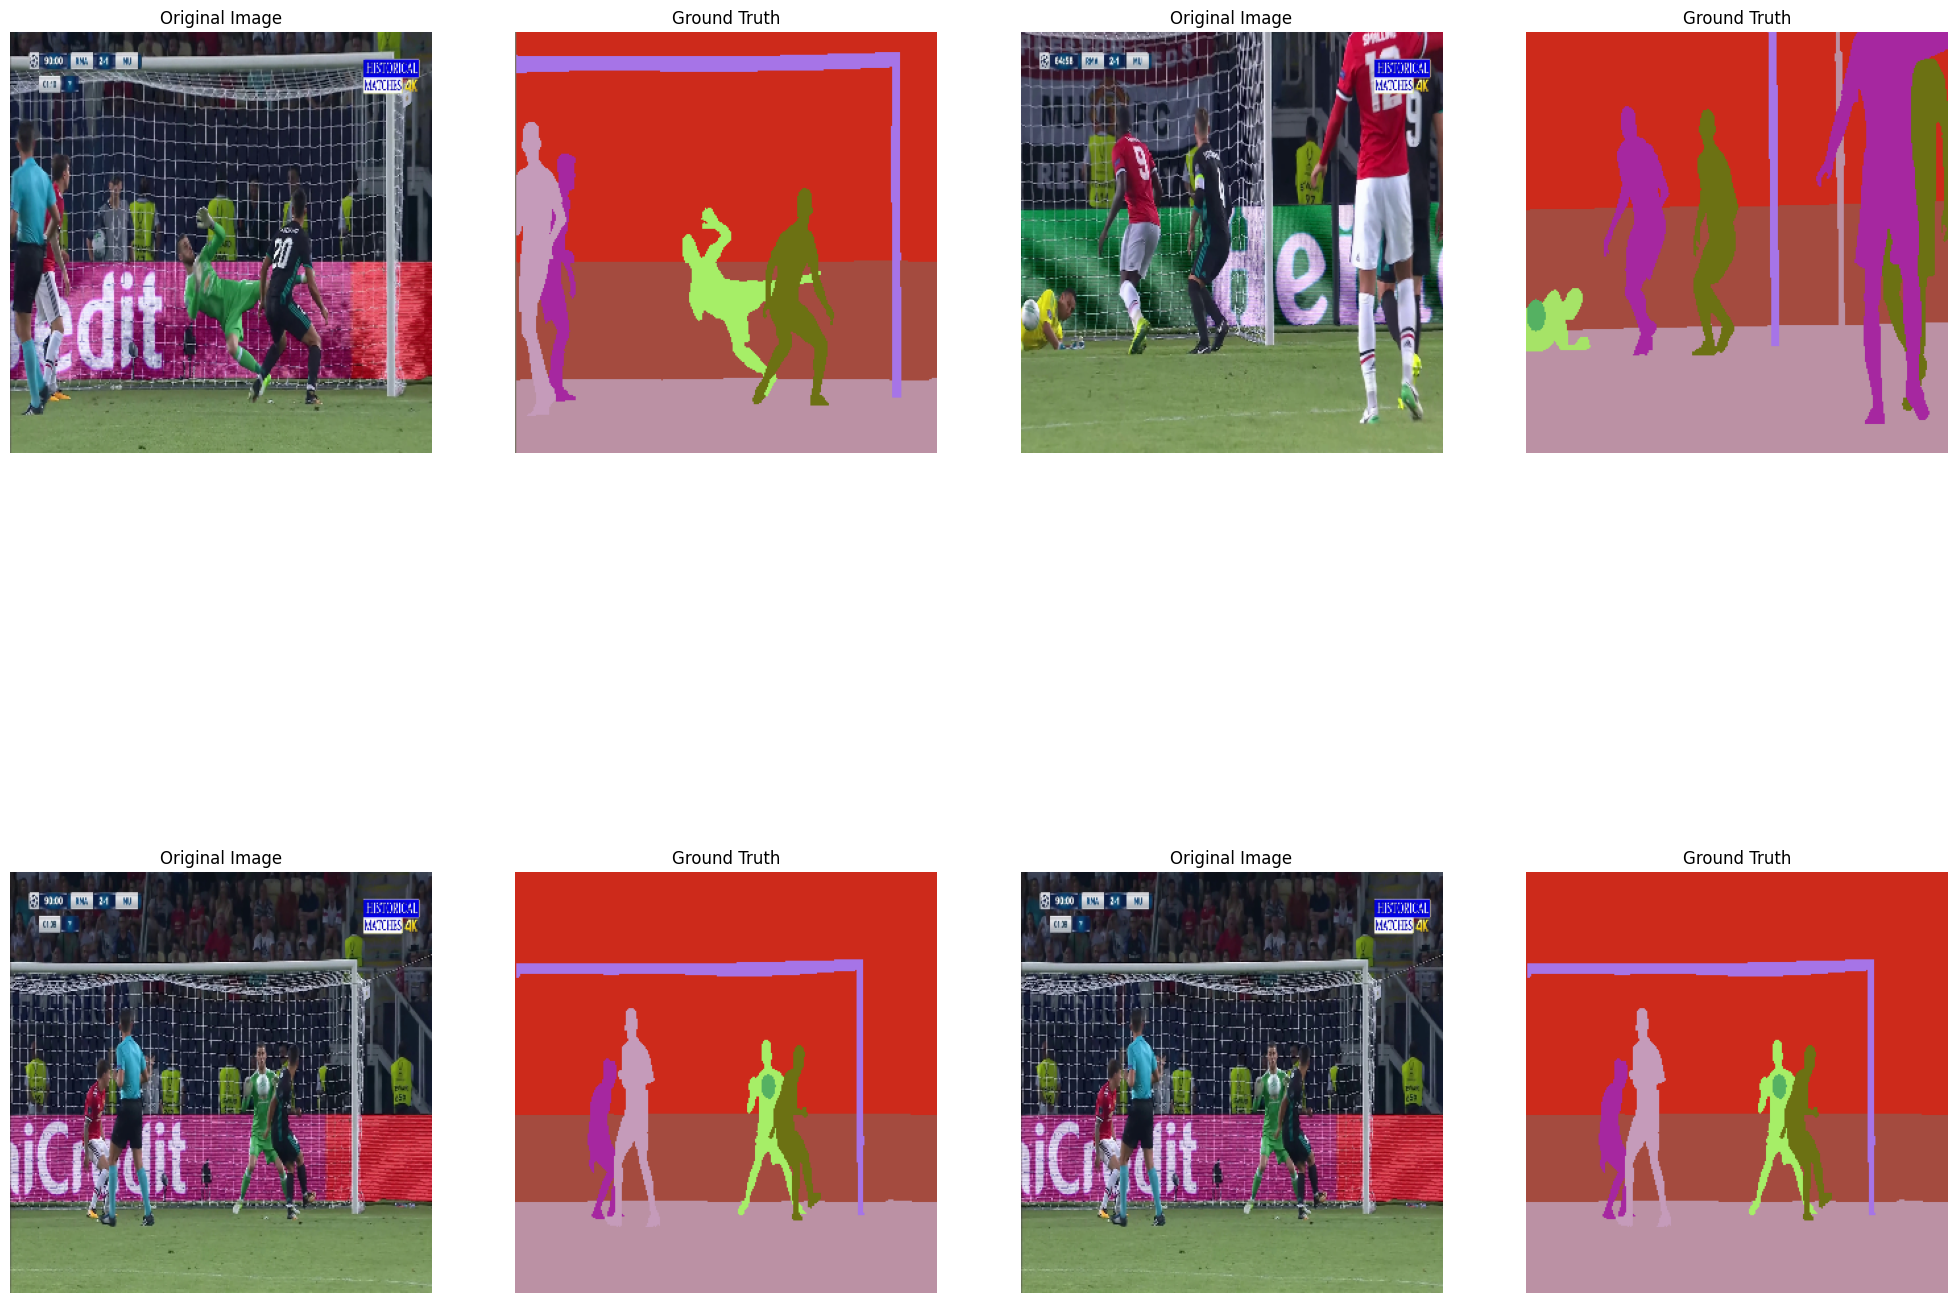

In [8]:
visualize_dataset(data_loaders['train'].dataset, num_images=8)


# Loading the model and create the optimizer

In [9]:
model = smp.DeepLabV3Plus(classes=n_cls)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 44.2MB/s]


In [10]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)


# Make the training functions

In [11]:
class Metrics:
    def __init__(self, pred, mask, loss_fn, eps=1e-10, n_cls=2):
        # Convert raw predictions to class indices using softmax
        self.pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
        self.mask = mask  # Ground truth labels
        self.loss_fn = loss_fn
        self.eps = eps
        self.n_cls = n_cls
        self.pred_ = pred 

    def to_contiguous(self, inp):
        return inp.contiguous().view(-1)

    def calculate_match(self, tensor1, tensor2):
        # Calculate element-wise equality between two tensors
        return torch.eq(tensor1, tensor2).int()

    def PA(self):
        with torch.no_grad():
            # Calculate element-wise equality between predictions and ground truth
            match = self.calculate_match(self.pred, self.mask)
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        with torch.no_grad():
            # Convert ground truth to class indices
            self.mask = torch.argmax(self.mask, dim=1)

            pred, mask = self.to_contiguous(self.pred), self.to_contiguous(self.mask)

            iou_per_class = []

            for c in range(self.n_cls):
                match_pred = pred == c
                match_mask = mask == c

                if match_mask.long().sum().item() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_mask).sum().float().item()
                    union = torch.logical_or(match_pred, match_mask).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self):
        # Calculate the loss using the provided loss function
        return self.loss_fn(self.pred_, torch.argmax(self.mask, dim=1))


In [12]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs):
    train_losses, train_pa, train_iou = [], [], []
    val_losses, val_pa, val_iou = [], [], []
    train_length, val_length = len(train_dataloader), len(val_dataloader)
    model.to(device)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    

    for epoch in range(1, epochs + 1):
        epoch_train_loss, epoch_train_iou, epoch_train_pa = 0, 0, 0
      
        model.train()
        print(f"Epoch {epoch} - Training process is started...")
        

        # Initialize tqdm with dynamic loss display
        train_progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for batch_idx, (images, targets) in train_progress_bar:
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            predictions = model(images)

            # Calculate metrics
            metrics = Metrics(predictions, targets, loss_fn, n_cls=n_cls)
            loss = metrics.loss()
            epoch_train_iou += metrics.mIoU()
            epoch_train_pa += metrics.PA()
            epoch_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            

            # Update tqdm with live loss display
            train_progress_bar.set_postfix({"Train Loss": loss.item()}, refresh=True)
            

        # Calculate average metrics for the training epoch
        epoch_train_loss /= train_length
        epoch_train_iou /=train_length
        epoch_train_pa /=train_length
        
        print(f"Epoch {epoch} train loss is {epoch_train_loss}  train PA is {epoch_train_pa} train mIoU is {epoch_train_iou}")


        # Log metrics to TensorBoard for training phase
        tensorboard_writer.add_scalar('Train Loss', epoch_train_loss, epoch)
        tensorboard_writer.add_scalar('Train PA', epoch_train_iou, epoch)
        tensorboard_writer.add_scalar('Train mIoU', epoch_train_pa, epoch)

        valid_loss_min = None
        epoch_val_loss, epoch_val_iou, epoch_val_pa = 0, 0, 0
        valid_progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for batch_idx, (val_images, val_targets) in valid_progress_bar:
            # Move tensors to device
            val_images, val_targets = val_images.to(device), val_targets.to(device)
            model.eval()
             
            # Forward pass for validation
            with torch.no_grad():
                val_predictions = model(val_images)
            
            # Calculate metrics for validation
            val_metrics = Metrics(val_predictions, val_targets, loss_fn, n_cls=n_cls)
            validation_loss = val_metrics.loss()
            
            
            epoch_val_loss+=validation_loss.item()
            if valid_loss_min is None or (
            (valid_loss_min - epoch_val_loss) / valid_loss_min > 0.01
        ):
                print(f"New minimum validation loss: {epoch_val_loss:.6f}. Saving model ...")

               # Save the weights to save_path
                torch.save(model, 'model.pth')

                valid_loss_min = epoch_val_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
            scheduler.step()
            
            
            epoch_val_iou+=val_metrics.mIoU()
            epoch_val_pa+=val_metrics.PA()
            
            epoch_val_loss /= val_length
            epoch_val_iou /= val_length
            epoch_val_pa /= val_length
            
            # Update tqdm with live loss display
            valid_progress_bar.set_postfix({"Validation Loss": validation_loss.item()}, refresh=True)
          
        
            
        # Log metrics to TensorBoard for validation phase
        tensorboard_writer.add_scalar('Validation Loss',epoch_val_loss, epoch)
        tensorboard_writer.add_scalar('Validation PA', epoch_val_pa, epoch)
        tensorboard_writer.add_scalar('Validation mIoU',  epoch_val_iou, epoch)
        print(f"Epoch {epoch} validation loss is {epoch_val_loss}  validation PA is {epoch_val_pa} validation mIoU is {epoch_val_iou}")


    # Close TensorBoard writer
    tensorboard_writer.close()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the data

In [13]:
train(model=model, train_dataloader=data_loaders['train'], val_dataloader=data_loaders['valid'],
                 loss_fn=loss, optimizer=optimizer, device=device,
                 epochs=15)


Epoch 1 - Training process is started...


100%|██████████| 23/23 [00:12<00:00,  1.91it/s, Train Loss=2.56]


Epoch 1 train loss is 2.6266156486842944  train PA is 0.023604470957880434 train mIoU is 0.022270536788300276


 50%|█████     | 1/2 [00:00<00:00,  2.47it/s, Validation Loss=2.4]

New minimum validation loss: 2.397683. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.04it/s, Validation Loss=2.4]


Epoch 1 validation loss is 1.7973846197128296  validation PA is 0.020386962890625 validation mIoU is 0.01630432682637353
Epoch 2 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, Train Loss=2.56]


Epoch 2 train loss is 2.5748242398966914  train PA is 0.03535251783288043 train mIoU is 0.03276376731858132


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.417795. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.99it/s, Validation Loss=2.37]


Epoch 2 validation loss is 1.787778913974762  validation PA is 0.09271484375 validation mIoU is 0.06846084562551362
Epoch 3 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.17it/s, Train Loss=2.51]


Epoch 3 train loss is 2.530748616094175  train PA is 0.045536472486413036 train mIoU is 0.04176630557162318


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.398175. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.43it/s, Validation Loss=2.33]


Epoch 3 validation loss is 1.767001211643219  validation PA is 0.12378234863281251 validation mIoU is 0.08870822766959519
Epoch 4 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.28it/s, Train Loss=2.47]


Epoch 4 train loss is 2.4893328314242154  train PA is 0.06257419752038042 train mIoU is 0.05550306424733864


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.369795. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.68it/s, Validation Loss=2.28]


Epoch 4 validation loss is 1.7328964471817017  validation PA is 0.15599243164062498 validation mIoU is 0.10518903303133698
Epoch 5 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.24it/s, Train Loss=2.41]


Epoch 5 train loss is 2.4410809433978535  train PA is 0.08236115828804347 train mIoU is 0.07216676933301883


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.331756. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Validation Loss=2.27]


Epoch 5 validation loss is 1.7162874341011047  validation PA is 0.1734185791015625 validation mIoU is 0.11610597996036497
Epoch 6 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.33it/s, Train Loss=2.38]


Epoch 6 train loss is 2.4157985604327656  train PA is 0.09754086701766304 train mIoU is 0.0862644460490707


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.331360. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.65it/s, Validation Loss=2.25]


Epoch 6 validation loss is 1.706693708896637  validation PA is 0.1874212646484375 validation mIoU is 0.12335370362778397
Epoch 7 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.34it/s, Train Loss=2.4]


Epoch 7 train loss is 2.4126335537951924  train PA is 0.09825142238451087 train mIoU is 0.08479823611008178


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.326978. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Validation Loss=2.24]


Epoch 7 validation loss is 1.7015356421470642  validation PA is 0.1856500244140625 validation mIoU is 0.12446394105535315
Epoch 8 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.24it/s, Train Loss=2.43]


Epoch 8 train loss is 2.409181605214658  train PA is 0.09837657099184781 train mIoU is 0.08611015006258035


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.310829. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Validation Loss=2.23]


Epoch 8 validation loss is 1.6918874979019165  validation PA is 0.2013671875 validation mIoU is 0.1315001114358558
Epoch 9 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.35it/s, Train Loss=2.42]


Epoch 9 train loss is 2.4046392855436904  train PA is 0.10318454908288043 train mIoU is 0.09039480913953915


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.315418. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.73it/s, Validation Loss=2.21]


Epoch 9 validation loss is 1.6861196160316467  validation PA is 0.20648132324218751 validation mIoU is 0.13707833286255594
Epoch 10 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.36it/s, Train Loss=2.4]


Epoch 10 train loss is 2.4016532068667202  train PA is 0.10652778957201084 train mIoU is 0.0923987316693195


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.302300. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.03it/s, Validation Loss=2.22]


Epoch 10 validation loss is 1.6875003576278687  validation PA is 0.20488891601562498 validation mIoU is 0.13523944589534487
Epoch 11 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.37it/s, Train Loss=2.4]


Epoch 11 train loss is 2.401992134425951  train PA is 0.10575810971467389 train mIoU is 0.09227518722369452


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.309649. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.76it/s, Validation Loss=2.21]


Epoch 11 validation loss is 1.681605339050293  validation PA is 0.216556396484375 validation mIoU is 0.1407144224547147
Epoch 12 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.39]


Epoch 12 train loss is 2.3998727902122168  train PA is 0.10425324813179347 train mIoU is 0.09048983583579294


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.321079. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Validation Loss=2.22]


Epoch 12 validation loss is 1.6922293305397034  validation PA is 0.2031732177734375 validation mIoU is 0.13420701014500896
Epoch 13 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.30it/s, Train Loss=2.38]


Epoch 13 train loss is 2.399631116701209  train PA is 0.10847221042798914 train mIoU is 0.09390128257473264


 50%|█████     | 1/2 [00:00<00:00,  2.50it/s, Validation Loss=2.31]

New minimum validation loss: 2.306196. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Validation Loss=2.21]


Epoch 13 validation loss is 1.6823612451553345  validation PA is 0.21347106933593749 validation mIoU is 0.13723452582564358
Epoch 14 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.30it/s, Train Loss=2.39]


Epoch 14 train loss is 2.399449286253556  train PA is 0.10888597571331518 train mIoU is 0.09450982487337155


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.308002. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  4.56it/s, Validation Loss=2.23]


Epoch 14 validation loss is 1.693485975265503  validation PA is 0.20175598144531248 validation mIoU is 0.13321468570156828
Epoch 15 - Training process is started...


100%|██████████| 23/23 [00:05<00:00,  4.38it/s, Train Loss=2.41]


Epoch 15 train loss is 2.3978639478268833  train PA is 0.10683264690896739 train mIoU is 0.09298425608781732


  0%|          | 0/2 [00:00<?, ?it/s]

New minimum validation loss: 2.306893. Saving model ...


100%|██████████| 2/2 [00:00<00:00,  3.74it/s, Validation Loss=2.23]

Epoch 15 validation loss is 1.6918044090270996  validation PA is 0.20557250976562502 validation mIoU is 0.13505880582791946


# Load best model and make some predictions

In [14]:
#visualize the predictions
def visualize_predictions(model, dataset, num_images, device):
    plt.figure(figsize=(25, 20))
    rows = num_images // 4
    cols = num_images // rows
    count = 1
    indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]

    model.to(device)
    model.eval()

    with torch.no_grad():
        for idx, index in enumerate(indices):
            if count == num_images + 1:
                break
            image, ground_truth = dataset[index]
            image = image.unsqueeze(0).to(device)

            # First Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(image.squeeze(0).float()))
            plt.axis("off")
            plt.title("Original Image")
            count += 1

            # Second Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(ground_truth.squeeze(0).float()))
            plt.axis("off")
            plt.title("Ground Truth")
            count += 1

            # Third Plot
            plt.subplot(rows, cols, count)
            plt.imshow(tensor_to_numpy(torch.argmax(model(image), dim=1).squeeze(0).float()))
            plt.axis("off")
            plt.title("Prediction")
            count += 1

In [15]:
model = torch.load('/kaggle/working/model.pth')


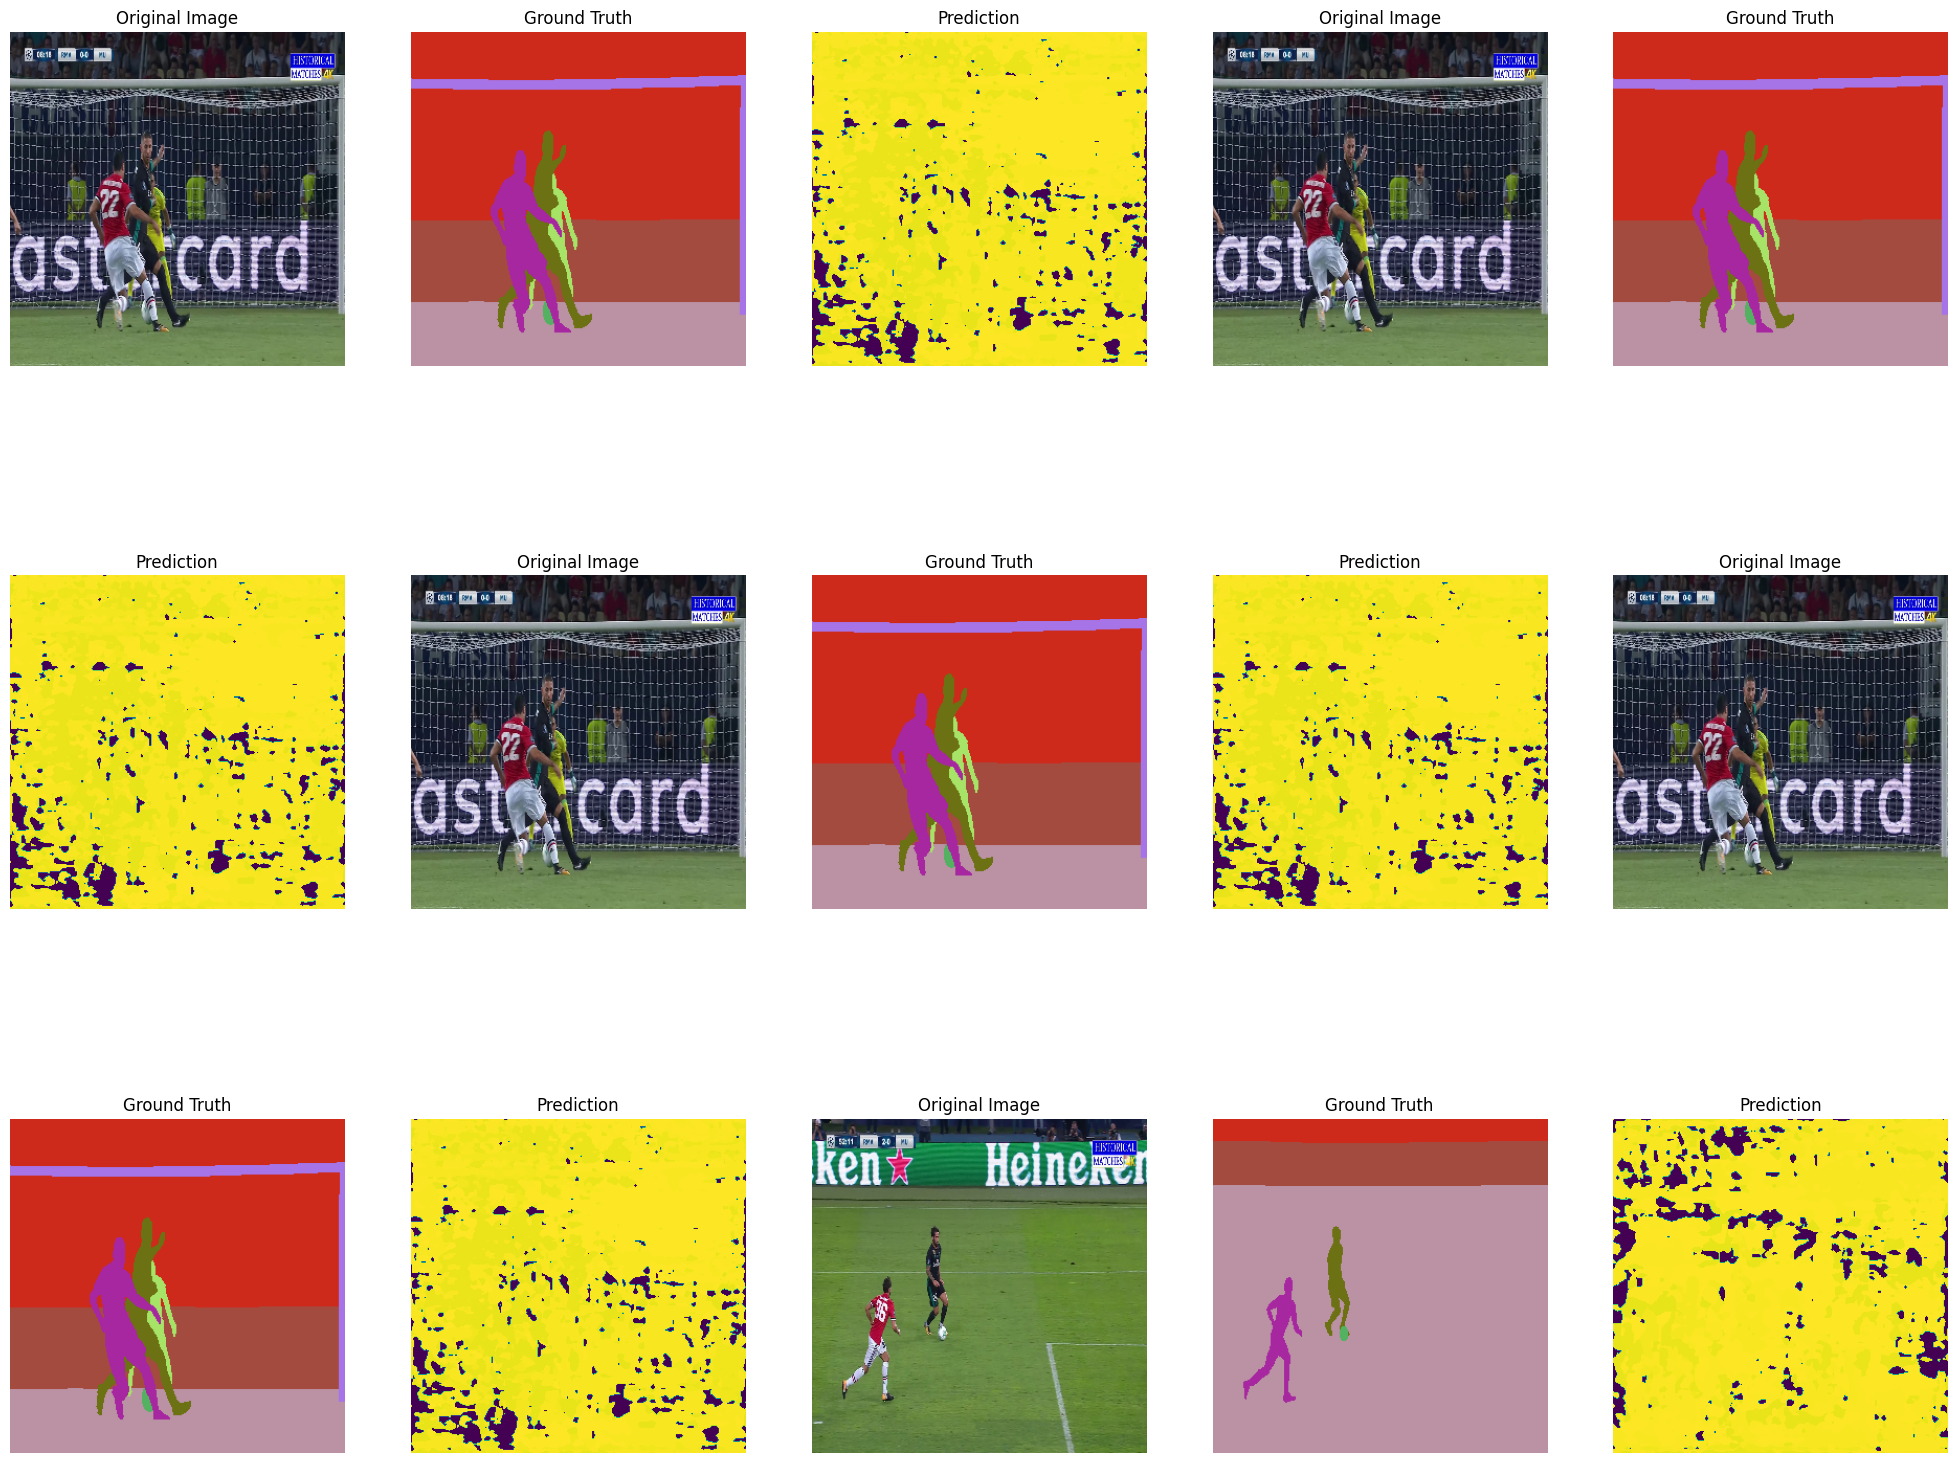

In [16]:
visualize_predictions(model, data_loaders['test'].dataset, num_images=15, device=device)
